In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
import matplotlib.cm as cm
from reverse_cmap import rcmap
import sys
import os
import errno
import netCDF4 as nc

BuRd = rcmap(cm.RdBu)

import hickle as hkl

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary


def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

a=6371.0e3
R=a

In [6]:
import glob
import numpy as np
import scipy.io as sio
import pylab as py
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import stats

#### Invoke all the files

m4 =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la4m_oc4m/*.hkl'))
m5 =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la5m_oc5m/*.hkl'))
m8 =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la8m_oc8m/*.hkl'))
m10 =(glob.glob('/project2/tas1/pragallva/Summer_quarter_2018/post_process_data/aqua_isca10m/*.hkl'))
m12 =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la12m_oc12m/*.hkl'))
m16 =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la16m_oc16m/*.hkl'))
m20 =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la20m_oc20m/*.hkl'))
m30 =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la30m_oc30m/*.hkl'))
m50 =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la50m_oc50m/*.hkl'))
m80 =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la80m_oc80m/*.hkl'))
m100 =(glob.glob('/project2/tas1/pragallva/Summer_quarter_2018/post_process_data/aqua_isca100m/*.hkl'))

In [7]:
# ls /project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la4m_oc4m/

In [9]:
DEPTHS=[m4, m5, m8, m10, m12, m16, m20, m30, m50, m80, m100]
flux=[]
flux_vert=[]
div=[]
div_vert=[]
eke=[]
raw=[]
tsurf=[]
mmc_decomp=[]
mmc_decomp_vert=[]
c=5
coord=load(m5[c])
for depth in DEPTHS:
    if ( (depth==m10) or (depth==m100)) :
        f=0; e=1; r=2; fv=3; c=4; d=5; dv=6;
    else :
        f=0; e=1; mmcv=2; r=3; fv=4; c=5; d=6; dv=7; mmc=8;
        mmc_decomp.append(load(depth[mmc]))
        eke.append(load(depth[e]))
        mmc_decomp.append(load(depth[mmc]))
        mmc_decomp_vert.append(load(depth[mmcv]))
    raw.append(load(depth[r]))
    flux.append(load(depth[f]))
    flux_vert.append(load(depth[fv]))
    div.append(load(depth[d])) 
    div_vert.append(load(depth[dv]))


In [10]:
c=5
ncfile='/project2/tas1/pragallva/Spring_quarter_2018/exp_data/aqua_isca5m/aqua_isca5m0.nc'
v_var=nc.Dataset(ncfile,'r')
sigma_full=v_var['pfull'][::-1]
sigma_half=v_var['phalf'][::-1]

In [11]:
# def save(X,name): 
#     Y={'d5':X[d5], 'd10':X[d10],'d50':X[d50], 'd100':X[d100]}
#     sio.savemat(name, Y)
# dest= '/project2/tas1/pragallva/Summer_quarter_2018/MAT_files/'  
# make_sure_path_exists(dest)
# save(flux,dest+"Isca_depths_FLUX_in_PW.mat")
# save(div, dest+"Isca_depths_DIV_in_W_m2.mat")
# save(raw, dest+"Isca_depths_RAW_data_all_levels.mat")
# sio.savemat(dest+"coordinates.mat", coord)

In [12]:
def M(x):
    return np.array(x)
lat=div[0]['latn']
Iswabs=[]; Ishf=[]; Idhdt=[]; Iolr=[]; Ine=[];
ISW_sfc=[]; ISW_toa=[]; ILW_sfc=[]; Ishflx=[]; Ilhflx=[]; ISFC=[]; ITOA=[]; TS=[]; precip=[]
for depth in range(len(DEPTHS)):
    Iswabs.append(M(flux[depth]['SWABS']))
    Ishf.append(M(flux[depth]['SHF']))
    Idhdt.append(M(flux[depth]['dhdt']))
    Iolr.append(M(flux[depth]['olr']))
    ISW_sfc.append(-1*M(flux[depth]['SW_sfc_d'])) ## up
    ILW_sfc.append(M(-1*flux[depth]['LW_sfc_d'])) ## up
    ISW_toa.append(M(flux[depth]['SW_toa_d']))    ## dn
    Ishflx.append(M(flux[depth]['shflx_u']))      ## up
    Ilhflx.append(M(flux[depth]['lhflx_u']))      ## up
    
    ISFC.append(M(flux[depth]['SFC_u']))
    ITOA.append(M(flux[depth]['TOA_d']))
    Ine.append(Iswabs[depth]+Ishf[depth]-Iolr[depth]-Idhdt[depth])

In [13]:
TE=[]; MM=[]; SE=[]; INE=[]; EKE_vert=[]; EMF_vert=[]; del_m_mmc=[]; del_v_mmc=[]
del_m_mmc_vert=[]; del_v_mmc_vert=[]
for depth in range(len(DEPTHS)):
    TE.append(M(flux[depth]['TE']))
    SE.append(M(flux[depth]['SE']))
    MM.append(M(flux[depth]['MM']))
    INE.append(TE[depth]+SE[depth]+MM[depth])

In [14]:
def M(X):
    return np.array(X)

In [15]:
import scipy.integrate as integrate 
def interad(x):
    l=np.deg2rad(lat[:,None])
    x=x*np.cos(l)
    #int_x  =integrate.cumtrapz(x[::-1,:],l[::-1],axis=0,initial=None) #  (This is basically integration from - 90 deg)
    int_x_r=integrate.cumtrapz(x        ,l      ,axis=0,initial=None) #  (This is basically integration from + 90 deg) 
    avg_int_r=2*np.pi*a**2*(int_x_r[:])#int_x_r[:-1,:]) #int_x[::-1,:][1:,:]+
    return avg_int_r/10**15

In [16]:
div_TE=[]; div_MM=[]; div_SE=[]; div_NE=[];
swabs=[]; shf=[]; olr=[];dhdt=[];ne=[];
SW_sfc=[]; SW_toa=[]; LW_sfc=[]; shflx=[]; lhflx=[]; sfc=[]; toa=[]

for depth in range(len(DEPTHS)):
    div_TE.append(div[depth]['TE'])
    div_SE.append(div[depth]['SE'])
    div_MM.append(div[depth]['MM'])
    div_NE.append(div_TE[depth]+div_SE[depth]+div_MM[depth])
    
    swabs.append(div[depth]['SWABS'])
    shf.append(div[depth]['SHF'])
    dhdt.append(div[depth]['dhdt'])
    olr.append(div[depth]['olr'])
    ne.append(swabs[depth]+shf[depth]-olr[depth]-dhdt[depth])
    
    SW_sfc.append(-1*div[depth]['SW_sfc_d'])
    LW_sfc.append(-1*div[depth]['LW_sfc_d'])
    SW_toa.append(div[depth]['SW_toa_d'])
    shflx.append(div[depth]['shflx_u'])
    lhflx.append(div[depth]['lhflx_u'])
    sfc.append(div[depth]['SFC_u'])
    toa.append(div[depth]['TOA_d'])
    

# Average Northern and Southern Hemispheres

In [17]:
TE=np.array(TE); SE=np.array(SE); MM=np.array(MM); NE=np.array(INE); EKE_vert=np.array(EKE_vert); EMF_vert=np.array(EMF_vert)
Iswabs=np.array(Iswabs); Ishf=np.array(Ishf); Ine=np.array(Ine); Iolr=np.array(Iolr); Idhdt=np.array(Idhdt);
ISW_sfc=np.array(ISW_sfc); ILW_sfc=np.array(ILW_sfc); ISW_toa=np.array(ISW_toa); Ishflx=np.array(Ishflx); Ilhflx=np.array(Ilhflx);
ISFC=np.array(ISFC); ITOA=np.array(ITOA); 
# mmc_decomp=np.array(mmc_decomp)

In [18]:
def N_S_avg(TE, SE, MM, NE, temp, lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))
    
    avg = lambda x: (x[:,l_N,:]+flux_flag*np.roll(x[:,l_S,:][:,::-1,:], 6, axis=-1))/2.0
    
    TE1= avg(TE)
    SE1= avg(SE)
    NE1= avg(NE)
    MM1= avg(MM)
    temp= avg(temp)
    
    a= lambda x: np.append(x,x[:,:,0,None],axis=-1)
    
    return a(TE1), a(SE1), a(MM1), a(NE1), a(temp), lat[l_N]

In [19]:
TE_a   ,SE_a     , MM_a  , NE_a  , NE_a,   lat_a  = N_S_avg(TE, SE, MM, NE, NE, lat)
Iswabs_a,Ishf_a  , Ine_a , Iolr_a, Idhdt_a, latr_a = N_S_avg( Iswabs,Ishf,Ine,Iolr,Idhdt, lat[1:-1] )
ISW_sfc_a, ILW_sfc_a  , ISW_toa_a , Ishflx_a, Ilhflx_a, latr_a = N_S_avg( ISW_sfc,ILW_sfc,ISW_toa, Ishflx, Ilhflx, lat[1:-1] )
ISFC_a = N_S_avg( ISFC,ISFC,ISFC,ISFC,ISFC, lat[1:-1] )[0]
ITOA_a = N_S_avg( ITOA,ITOA,ITOA,ITOA,ITOA, lat[1:-1] )[0]


In [20]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div(x,fac=1):
       N=100
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for m in range(13):
           div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat_a[:])) ),N)
       return div

div_TE_a=spher_div(TE_a*10**15)
div_SE_a=spher_div(SE_a*10**15)
div_MM_a=spher_div(MM_a*10**15)
div_NE_a=div_TE_a+div_SE_a+div_MM_a

In [21]:
lat=div[0]['latn']

from scipy.interpolate import interp1d

def find_zero(div):
  zero_loc = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
      for m in range(0,13):
            l_range=((lat_a>=30) & (lat_a<=60))            
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

storm_pos=find_zero(div_TE_a)

In [22]:
import numpy as np
def calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=1):
    
    div_TE_a=spher_div(TE_a*10**15)
    div_SE_a=spher_div(SE_a*10**15)
    div_MM_a=spher_div(MM_a*10**15)
    div_NE_a=div_TE_a+div_SE_a+div_MM_a
    
    se=np.array(div_SE_a); te=np.array(div_TE_a); mm=np.array(div_MM_a); ne=np.array(div_NE_a)
    
    def diff(x):
        return x[:,:,1:]-x[:,:,:-1] 
    base_pos=te[...,:-1]
    
    if month_to_month==0 :
      def diff(x):
         return x[:,:,1:]-x[...,1:,None].mean(axis=2)    
      base_pos=te[...,1:,None].mean(axis=2)
        
    TE_change=base_pos+diff(te)
    NE_change=base_pos+diff(ne)
    SE_change=base_pos-diff(se)
    MM_change=base_pos-diff(mm)
    
    a = lambda x: np.append(x[:,:,-1,None],x,axis=-1)
    
    return a(SE_change), a(MM_change), a(TE_change), a(NE_change)

SE_change, MM_change, TE_change, NE_change = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=0)

In [23]:
def find_zero(div,lower_limit=30,specific_month=-1):
  depths=div.shape[0];
  months=div.shape[-1];
  zero_loc = np.zeros((depths,months))
  for d in range(0,depths):
      for m in range(0,months):
            l_range=((lat_a>=30) & (lat_a<=60))   
            if m==specific_month:
                l_range=((lat_a>=lower_limit) & (lat_a<=60))
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

In [24]:
def find_zero_for_ann_mean(div):
  depths=div.shape[0];
  zero_loc = np.zeros(depths)
  for d in range(0,depths):
        l_range=((lat_a>=30) & (lat_a<=60))   
        interpolation_function = interp1d(div[d,l_range,:-1].mean(axis=-1),lat_a[l_range],kind='linear')
        try :
                zero_loc[d]=interpolation_function(0)
        except ValueError as err:
                zero_loc[d]=np.nan        
  return zero_loc
ann_pos=find_zero_for_ann_mean(TE_change)

In [25]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  D = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=storm_pos
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[d,m]==np.nan        
  return D

Intensity_te=inerp_at_max(TE_a,lat_a)
Intensity_se=inerp_at_max(SE_a,lat_a)
Intensity_mm=inerp_at_max(MM_a,lat_a)
Intensity_ne=inerp_at_max(NE_a,lat_a)


I_SWAB =inerp_at_max(Iswabs_a,latr_a)
I_SHF  =inerp_at_max(Ishf_a,latr_a)
I_NE   =inerp_at_max(Ine_a,latr_a)
I_OLR  =inerp_at_max(Iolr_a,latr_a)
I_dhdt =inerp_at_max(Idhdt_a,latr_a)

I_SWsfc = inerp_at_max(ISW_sfc_a,latr_a)
I_LWsfc = inerp_at_max(ILW_sfc_a,latr_a)
I_SWtoa = inerp_at_max(ISW_toa_a,latr_a)
I_shflx = inerp_at_max(Ishflx_a,latr_a)
I_lhflx = inerp_at_max(Ilhflx_a,latr_a)

I_SFC = inerp_at_max(ISFC_a,latr_a)
I_TOA = inerp_at_max(ITOA_a,latr_a)


In [26]:
def threshold(I,value, pos1, pos2, pos3, pos4):
      for d in range(len(DEPTHS)):  
        for m in range(13):
            if (np.abs(I[d,m])<value) :
                #N[d,m]=np.nan
                pos1[d,m]=np.nan
                pos2[d,m]=np.nan
                pos3[d,m]=np.nan
                pos4[d,m]=np.nan                
      return pos1, pos2, pos3, pos4
zero_div_TE, zero_div_SE, zero_div_MM, zero_div_NE = threshold(Intensity_te, 0.0, find_zero(TE_change), find_zero(SE_change), find_zero(MM_change), find_zero(NE_change))

In [27]:
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')


# Decompose Net energy in Watts/m^2

In [28]:
swabs=np.array(swabs); shf=np.array(shf); ne=np.array(ne); olr=np.array(olr); dhdt=np.array(dhdt);
SW_sfc=np.array(SW_sfc); LW_sfc=np.array(LW_sfc); SW_toa=np.array(SW_toa); shflx=np.array(shflx); lhflx=np.array(lhflx);
sfc=np.array(sfc); toa=np.array(toa); 

In [29]:
SWABS_a, SHF_a  , NE_a , OLR_a, dhdt_a, lat_a = N_S_avg( swabs,shf, ne ,olr, dhdt, lat, flux_flag=1)
SW_toa_a, SW_sfc_a  , shflx_a , lhflx_a, LW_sfc_a, lat_a = N_S_avg( SW_toa, SW_sfc, shflx, lhflx, LW_sfc, lat,flux_flag=1)#

SW_toa_a, SW_sfc_a  , shflx_a , lhflx_a, LW_sfc_a, lat_a = N_S_avg( SW_toa, SW_sfc, shflx, lhflx, LW_sfc, lat,flux_flag=1)#
sfc_a, toa_a = N_S_avg( sfc, toa, shflx, lhflx, LW_sfc, lat,flux_flag=1)[0:2]


In [30]:
def inerp_at_mean(flux,lat):
  D = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=np.nanmean(zero_div_TE[d,:-1])
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X)
        except ValueError as err:
            D[d,m]==np.nan        
  return D

In [31]:
P_div_TE =inerp_at_mean(div_TE_a,lat_a)
P_div_SE =inerp_at_mean(div_SE_a,lat_a)
P_div_NE =inerp_at_mean(div_NE_a,lat_a)
P_div_MM =inerp_at_mean(div_MM_a,lat_a)

In [32]:
P_SWAB =inerp_at_max(SWABS_a,lat_a)
P_SHF  =inerp_at_max(SHF_a,lat_a)
P_NE   =inerp_at_max(NE_a,lat_a)
P_OLR  =inerp_at_max(OLR_a,lat_a)
P_dhdt =inerp_at_max(dhdt_a,lat_a)

P_SWsfc = inerp_at_max(SW_sfc_a,lat_a)
P_LWsfc = inerp_at_max(LW_sfc_a,lat_a)
P_SWtoa = inerp_at_max(SW_toa_a,lat_a)
P_shflx = inerp_at_max(shflx_a,lat_a)
P_lhflx = inerp_at_max(lhflx_a,lat_a)

P_sfc = inerp_at_max(sfc_a,lat_a)
P_toa = inerp_at_max(toa_a,lat_a)

In [33]:
# m_to_m=0; l=6
# fig=py.figure(figsize=(22, 15))
# compare_plot(1,I_lhflx,'r',r'$\Delta I_{lhfx}$',m_to_m,l)
# compare_plot(2,I_shflx,'b',r'$\Delta I_{shflx}$',m_to_m,l)
# compare_plot(3,I_LWsfc,'g',r'$ \Delta I_{LW\:sfc}$',m_to_m,l)
# compare_plot(4,I_SWsfc,'m',r'$\Delta I_{SW\:sfc}$',m_to_m,l)

In [34]:
I_SWAB =inerp_at_max(Iswabs_a,latr_a)
I_SHF  =inerp_at_max(Ishf_a,latr_a)
I_NE   =inerp_at_max(Ine_a,latr_a)
I_OLR  =inerp_at_max(Iolr_a,latr_a)
I_dhdt =inerp_at_max(Idhdt_a,latr_a)

I_SWsfc = inerp_at_max(ISW_sfc_a,latr_a)
I_LWsfc = inerp_at_max(ILW_sfc_a,latr_a)
I_SWtoa = inerp_at_max(ISW_toa_a,latr_a)
I_shflx = inerp_at_max(Ishflx_a,latr_a)
I_lhflx = inerp_at_max(Ilhflx_a,latr_a)

I_SFC = inerp_at_max(ISFC_a,latr_a)
I_TOA = inerp_at_max(ITOA_a,latr_a)

In [35]:
flux_vert[0]['MM'].shape

(1741, 40, 12)

## Look at raw data

In [36]:
T=[]; Q=[]; U=[]; V=[]; Z=[]; EKE=[]; EMF=[];
MMv=[]; SEv=[]; NEv=[]; TEv=[];
divMMv=[]; divSEv=[]; divNEv=[]; divTEv=[];

for depth in range(len(DEPTHS)):
    T.append(M(raw[depth]['T']))
    Q.append(M(raw[depth]['q']))
    U.append(M(raw[depth]['U']))
    V.append(M(raw[depth]['V']))
    Z.append(M(raw[depth]['Z']))
    
    MMv.append(M(flux_vert[depth]['MM']))
    SEv.append(M(flux_vert[depth]['SE']))
    TEv.append(M(flux_vert[depth]['TE']))
    NEv.append(M(flux_vert[depth]['NE']))
        
    divMMv.append(M(div_vert[depth]['MM']))
    divSEv.append(M(div_vert[depth]['SE']))
    divTEv.append(M(div_vert[depth]['TE']))
    divNEv.append(M(div_vert[depth]['NE']))
    
T=np.array(T); U=np.array(U); V=np.array(V); Z=np.array(Z); Q=np.array(Q); EKE=np.array(EKE); EMF= np.array(EMF)
MMv=np.array(MMv); SEv=np.array(SEv); TEv=np.array(TEv); NEv=np.array(NEv);
divMMv=np.array(divMMv); divSEv=np.array(divSEv); divTEv=np.array(divTEv); divNEv=np.array(divNEv);

In [37]:
# print T.shape
# print TS_a.shape

In [38]:
def N_S_avg(TE, SE, MM, NE, temp, lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))
    
    avg = lambda x: (x[:,l_N,:,:]+flux_flag*np.roll(x[:,l_S,:,:][:,::-1,:,:], 6, axis=-1))/2.0
    
    TE1= avg(TE)
    SE1= avg(SE)
    NE1= avg(NE)
    MM1= avg(MM)
    temp= avg(temp)
    
    a= lambda x: np.append(x,x[...,0,None],axis=-1)
    
    return a(TE1), a(SE1), a(MM1), a(NE1), a(temp), lat[l_N]

In [39]:
T_a      , U_a,       V_a   , Q_a,    Z_a,  lat_a             = N_S_avg(T, U, V, Q, Z, lat,flux_flag=1)
MMv_a    , SEv_a,     TEv_a   , NEv_a,    NEv_a,  lat_a       = N_S_avg(MMv   , SEv,     TEv  ,  NEv,   NEv, lat,flux_flag=-1)
divMMv_a , divSEv_a,  divTEv_a  , divNEv_a,  divNEv_a,  lat_a    = N_S_avg(divMMv, divSEv,  divTEv, divNEv, divNEv, lat,flux_flag=1)


### Calculate the temperature gradient

In [40]:
def spher_div_for_full_field(x,fac=1):
       N=50
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
         for m in range(12):
            for p in range(len(sigma_full)):
              div[d,:,p,m]= smooth( np.gradient((x[d,:,p,m])*(fac),dtheta)/( R*np.cos(np.radians(lat[:])) ),N)
       return div

In [41]:
sigma_full=eke[0]['sigma_full']

Cp= 1004.64 # J/kg/deg
g = 9.8
L = 2.500e6   # J/kg

In [42]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div_for_full_field(x,fac=1):
       N=50
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
         for m in range(13):
            for p in range(len(sigma_full)):
              div[d,:,p,m]= smooth( np.gradient((x[d,:,p,m])*(fac),dtheta)/( R*np.cos(np.radians(lat_a[:])) ),N)
       return div


def spher_div_for_temp(x):
       N=50
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
         for m in range(13):
              div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( R*np.cos(np.radians(lat_a[:])) ),N )
       return div


divCpT_a = spher_div_for_full_field(Cp*T_a)
divLq_a  = spher_div_for_full_field(L*Q_a)
divgZ_a  = spher_div_for_full_field(g*Z_a)
divMSE_a = spher_div_for_full_field(Cp*T_a+g*Z_a+L*Q_a)



In [43]:
def ann_mean(y):
    return np.squeeze(np.dstack([y[:,:,:,:].mean(axis=-1)]))

In [44]:
zero_div_TE.shape

(11, 13)

In [47]:
def amp(X,d):
    A=np.zeros(len(DEPTHS))
    for d in range(len(DEPTHS)):
       A[d]=np.nanmax(X[d,:])-np.nanmin(X[d,:]) 
    return A
depth_values=[4, 5, 8, 10,12, 16, 20,30, 50,80, 100]

Iamp=amp(Intensity_te,d)
NEamp=amp(Intensity_ne,d)
MMamp=amp(Intensity_mm,d)
MMamp=amp(Intensity_mm,d)

Pamp=amp(zero_div_TE,d)
Pseamp=amp(zero_div_SE,d)
Pmmamp=amp(zero_div_MM,d)
Pneamp=amp(zero_div_NE,d)

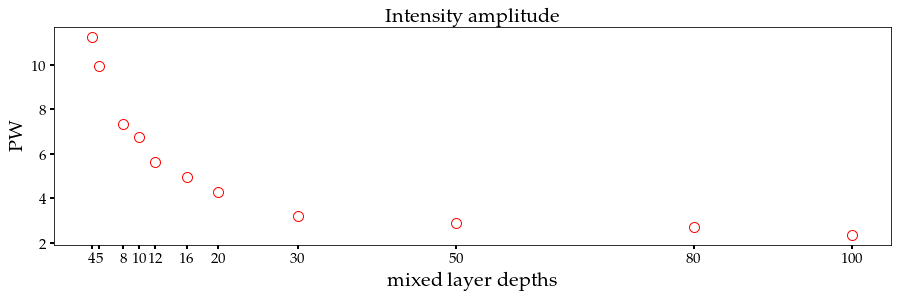

In [57]:
py.figure(figsize=(15,4))
py.plot(depth_values,Iamp,'ro',markersize=10, mfc='none')
py.xticks(depth_values)
py.tick_params(labelsize=15,size=4,width=2)
py.title("Intensity amplitude",fontsize=20)
py.ylabel("PW",fontsize=20)
py.xlabel("mixed layer depths",fontsize=20)
# py.plot(depth_values,NEamp,'mo',markersize=10, mfc='none')
# py.plot(depth_values,MMamp,'go',markersize=10, mfc='none')

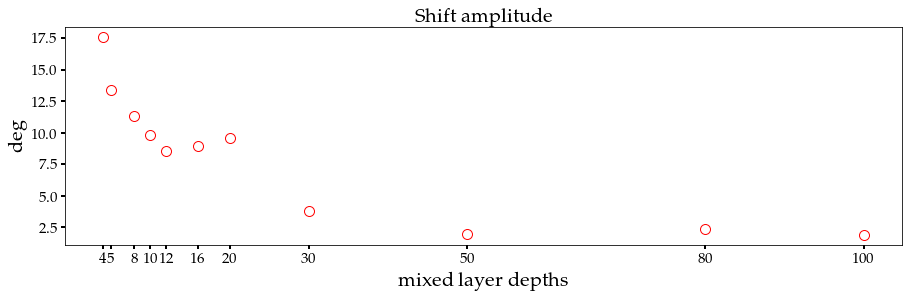

In [139]:
py.figure(figsize=(15,4))
py.plot(depth_values,Pamp,'ro',markersize=10, mfc='none')
py.xticks(depth_values)
py.tick_params(labelsize=15,size=4,width=2)
py.title("Shift amplitude",fontsize=20)
py.ylabel("deg",fontsize=20)
py.xlabel("mixed layer depths",fontsize=20)
# py.plot(depth_values,Pneamp,'mo-',markersize=10)
# py.plot(depth_values,Pmmamp,'go-',markersize=10)
# py.plot(depth_values,Pseamp,'bo-',markersize=10)


In [126]:
def maxx(X):
    A=np.zeros(len(DEPTHS))
    for d in range(len(DEPTHS)):
       A[d]=np.nanmax(X[d,:])
    return A

def minn(X):
    A=np.zeros(len(DEPTHS))
    for d in range(len(DEPTHS)):
       A[d]=np.nanmin(X[d,:])
    return A

depth_values=[4, 5, 8, 10,12, 16, 20,30, 50,80, 100]

maxpos=maxx(zero_div_TE)
minpos=minn(zero_div_TE)


In [127]:
maxpos

array([56.7636964 , 53.55813694, 49.40864698, 47.89185182, 46.36560423,
       46.66775737, 47.48986305, 41.01884775, 39.50453277, 38.92911921,
       38.7676745 ])

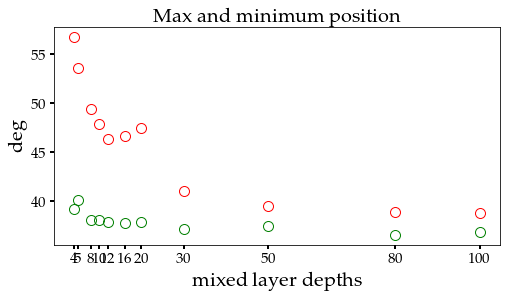

In [138]:
py.figure(figsize=(8,4))
py.plot(depth_values,(maxpos),'ro',markersize=10, mfc='none')
py.plot(depth_values,(minpos),'go',markersize=10, mfc='none')
py.xticks(depth_values)
py.tick_params(labelsize=15,size=4,width=2)
py.title("Max and minimum position",fontsize=20)
py.ylabel("deg",fontsize=20)
py.xlabel("mixed layer depths",fontsize=20)
# py.plot(depth_values,Pneamp,'mo-',markersize=10)
# py.plot(depth_values,Pmmamp,'go-',markersize=10)
# py.plot(depth_values,Pseamp,'bo-',markersize=10)

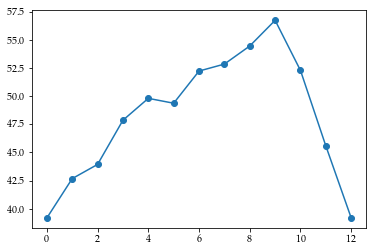

In [145]:
D=1
for d in range(D):
    py.plot(range(13),(zero_div_TE[d,:]),'o-')
# py.ylim(30,54)

In [148]:
TE_a.shape

(11, 871, 13)

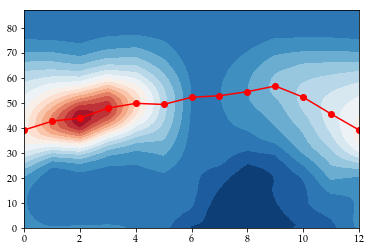

In [195]:
d=0
py.contourf(range(13),lat_a,TE_a[d,...],20,cmap=BuRd)
py.plot(range(13),zero_div_TE[d,:],'ro-')
# # py.contour(range(13),lat_a,TE_a[10,...],cmap=BuRd)

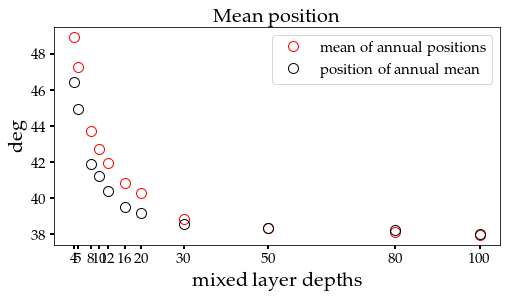

In [143]:
py.figure(figsize=(8,4))
py.plot(depth_values,zero_div_TE[:,:-1].mean(axis=-1),'ro',markersize=10, mfc='none',label="mean of annual positions")
py.plot(depth_values,ann_pos,'ko',markersize=10, mfc='none',label="position of annual mean")
py.xticks(depth_values)
py.tick_params(labelsize=15,size=4,width=2)
py.title("Mean position",fontsize=20)
py.legend(loc="best",fontsize=15)
py.ylabel("deg",fontsize=20)
py.xlabel("mixed layer depths",fontsize=20)
# py.plot(depth_values,Pneamp,'mo-',markersize=10)
# py.plot(depth_values,Pmmamp,'go-',markersize=10)
# py.plot(depth_values,Pseamp,'bo-',markersize=10)

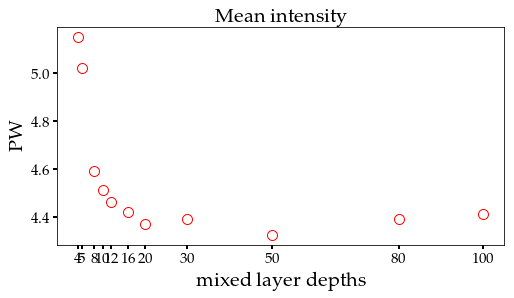

In [53]:
py.figure(figsize=(8,4))
py.plot(depth_values,Intensity_te[:,:-1].mean(axis=-1),'ro',markersize=10, mfc='none')
py.xticks(depth_values)
py.tick_params(labelsize=15,size=4,width=2)
py.title("Mean intensity",fontsize=20)
py.ylabel("PW",fontsize=20)
py.xlabel("mixed layer depths",fontsize=20)
# py.plot(depth_values,Pneamp,'mo-',markersize=10)
# py.plot(depth_values,Pmmamp,'go-',markersize=10)
# py.plot(depth_values,Pseamp,'bo-',markersize=10)

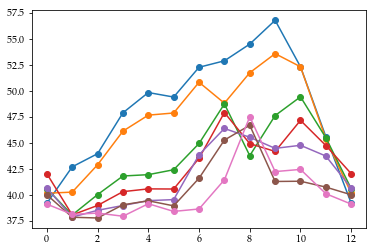

In [56]:
for d in range(7):
    py.plot(range(13),(zero_div_TE[d,:]),'o-')
# py.ylim(30,54)

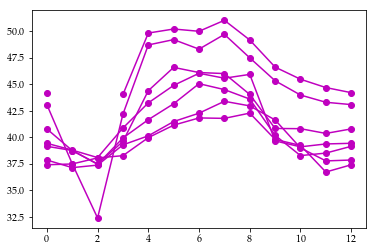

In [59]:
for d in range(7):
    py.plot(range(13),(zero_div_NE[d,:]),'mo-')
# py.ylim(30,54)

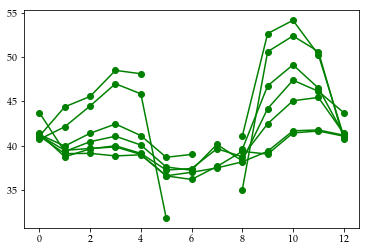

In [60]:
for d in range(7):
    py.plot(range(13),(zero_div_MM[d,:]),'go-')
# py.ylim(30,54)

In [62]:
def di(x,d):
    return x-ann_pos[d]

(-10, 10)

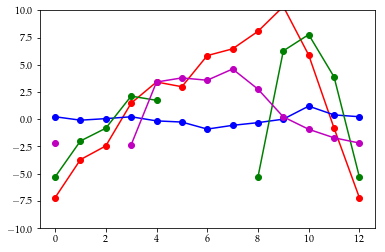

In [63]:
for d in range(1):
    py.plot(range(13),di(zero_div_TE[d,:],d),'ro-')
    py.plot(range(13),di(zero_div_SE[d,:],d),'bo-')
    py.plot(range(13),di(zero_div_MM[d,:],d),'go-')
    py.plot(range(13),di(zero_div_NE[d,:],d),'mo-')
#     py.axhline(ann_pos[d],c='k')
py.ylim(-10,10)

(-10, 10)

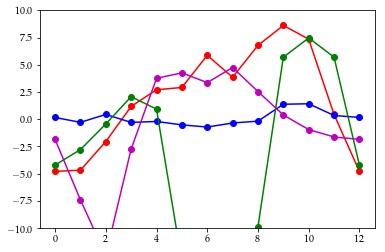

In [64]:
for d in range(1,2):
    py.plot(range(13),di(zero_div_TE[d,:],d),'ro-')
    py.plot(range(13),di(zero_div_SE[d,:],d),'bo-')
    py.plot(range(13),di(zero_div_MM[d,:],d),'go-')
    py.plot(range(13),di(zero_div_NE[d,:],d),'mo-')
#     py.axhline(ann_pos[d],c='k')
py.ylim(-10,10)

(-10, 10)

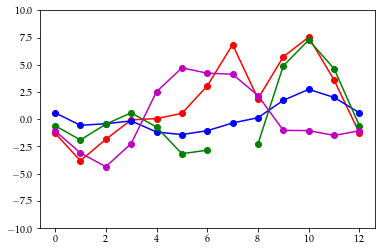

In [66]:
for d in range(2,3):
    py.plot(range(13),di(zero_div_TE[d,:],d),'ro-')
    py.plot(range(13),di(zero_div_SE[d,:],d),'bo-')
    py.plot(range(13),di(zero_div_MM[d,:],d),'go-')
    py.plot(range(13),di(zero_div_NE[d,:],d),'mo-')
    py.axhline(ann_pos[d],c='k')
py.ylim(-10,10)

(-10, 10)

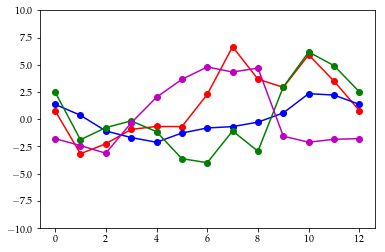

In [67]:
for d in range(3,4):
    py.plot(range(13),di(zero_div_TE[d,:],d),'ro-')
    py.plot(range(13),di(zero_div_SE[d,:],d),'bo-')
    py.plot(range(13),di(zero_div_MM[d,:],d),'go-')
    py.plot(range(13),di(zero_div_NE[d,:],d),'mo-')
    py.axhline(ann_pos[d],c='k')
py.ylim(-10,10)

(-10, 10)

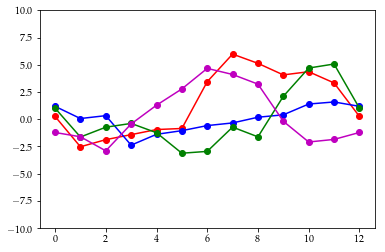

In [68]:
for d in range(4,5):
    py.plot(range(13),di(zero_div_TE[d,:],d),'ro-')
    py.plot(range(13),di(zero_div_SE[d,:],d),'bo-')
    py.plot(range(13),di(zero_div_MM[d,:],d),'go-')
    py.plot(range(13),di(zero_div_NE[d,:],d),'mo-')
    py.axhline(ann_pos[d],c='k')
py.ylim(-10,10)

(-10, 10)

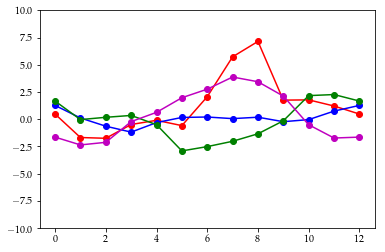

In [69]:
for d in range(5,6):
    py.plot(range(13),di(zero_div_TE[d,:],d),'ro-')
    py.plot(range(13),di(zero_div_SE[d,:],d),'bo-')
    py.plot(range(13),di(zero_div_MM[d,:],d),'go-')
    py.plot(range(13),di(zero_div_NE[d,:],d),'mo-')
    py.axhline(ann_pos[d],c='k')
py.ylim(-10,10)

(-10, 10)

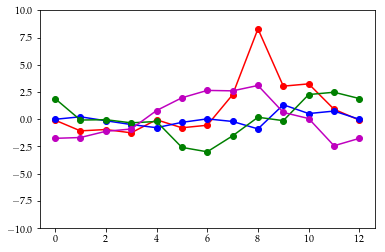

In [70]:
for d in range(6,7):
    py.plot(range(13),di(zero_div_TE[d,:],d),'ro-')
    py.plot(range(13),di(zero_div_SE[d,:],d),'bo-')
    py.plot(range(13),di(zero_div_MM[d,:],d),'go-')
    py.plot(range(13),di(zero_div_NE[d,:],d),'mo-')
    py.axhline(ann_pos[d],c='k')
py.ylim(-10,10)

(-10, 10)

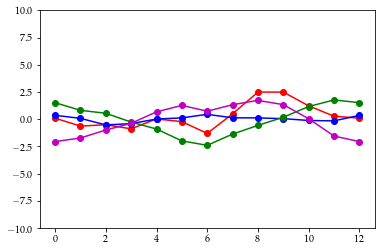

In [71]:
for d in range(7,8):
    py.plot(range(13),di(zero_div_TE[d,:],d),'ro-')
    py.plot(range(13),di(zero_div_SE[d,:],d),'bo-')
    py.plot(range(13),di(zero_div_MM[d,:],d),'go-')
    py.plot(range(13),di(zero_div_NE[d,:],d),'mo-')
    py.axhline(ann_pos[d],c='k')
py.ylim(-10,10)

(0, 12)

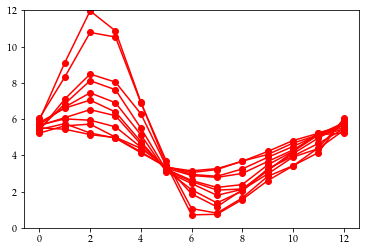

In [72]:
for d in range(len(DEPTHS)):
    py.plot(range(13),Intensity_te[d,:],'ro-')
py.ylim(0,12)

(0, 12)

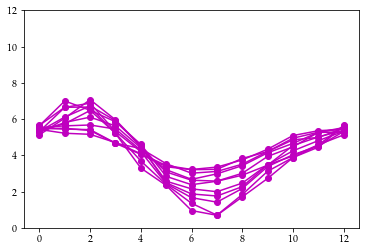

In [73]:
for d in range(len(DEPTHS)):
    py.plot(range(13),Intensity_ne[d,:],'mo-')
py.ylim(0,12)

(0, 12)

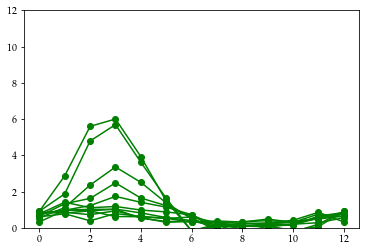

In [74]:
for d in range(len(DEPTHS)):
    py.plot(range(13),-Intensity_mm[d,:],'go-')
py.ylim(0,12)

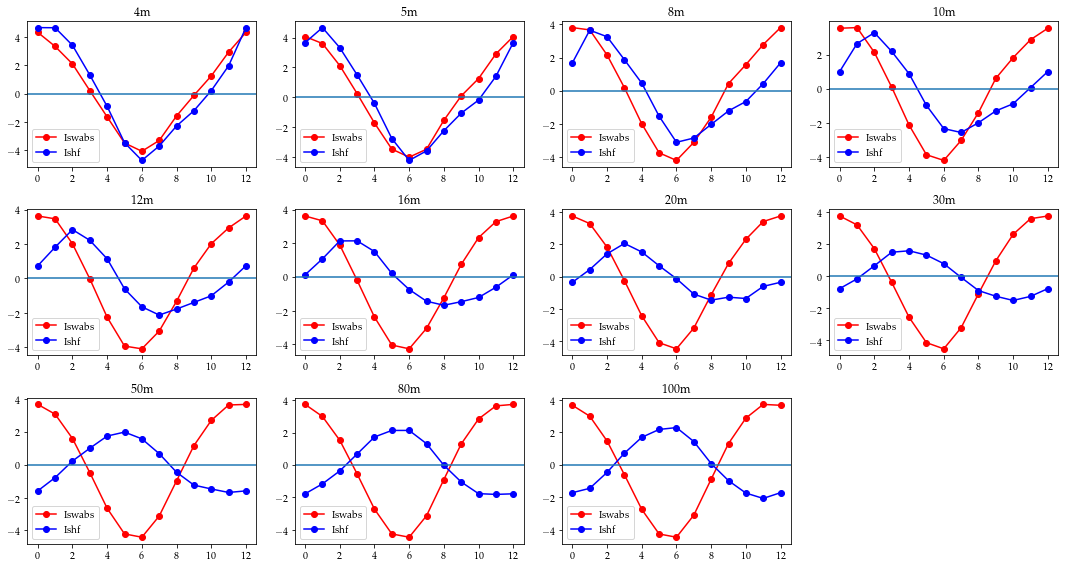

In [121]:
alldepths=[4,5,8,10,12,16,20,30,50,80,100]
py.figure(figsize=(15,8))
def a(x):
    return x-x[:-1].mean(axis=-1)
for i in range(len(DEPTHS)):
    py.subplot(3,4,i+1)
    d=i; py.title(str(alldepths[d])+"m")
    py.plot(range(13),a(I_SWAB[d,:]),'ro-',label="Iswabs")
    py.plot(range(13),a(I_SHF[d,:]),'bo-',label="Ishf")
    py.axhline(0)
    py.legend(loc='best')
py.tight_layout()
# py.ylim(35,54)

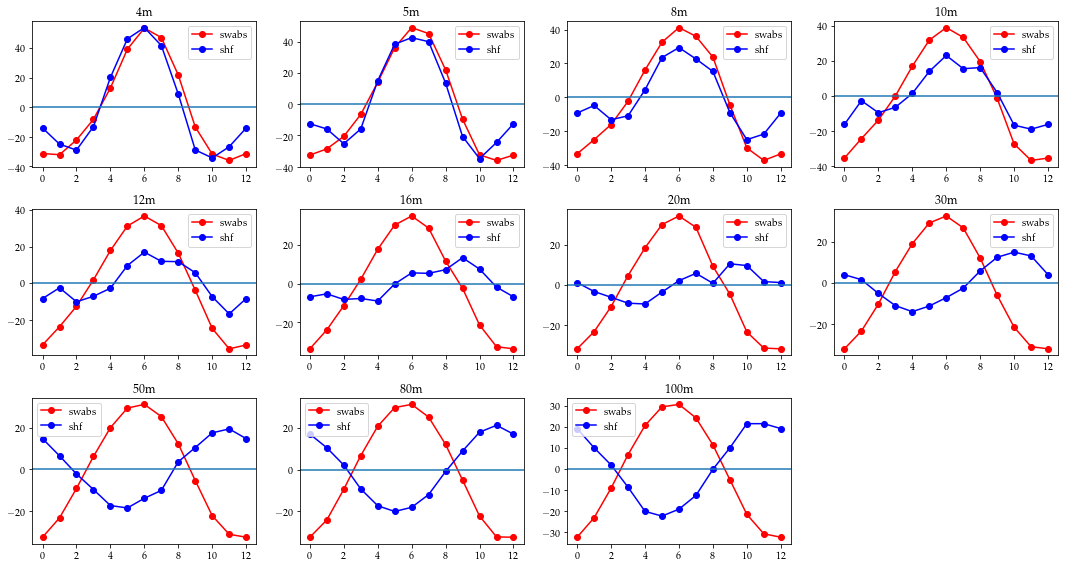

In [122]:
alldepths=[4,5,8,10,12,16,20,30,50,80,100]
py.figure(figsize=(15,8))
def a(x):
    return x-x[:-1].mean(axis=-1)
for i in range(len(DEPTHS)):
    py.subplot(3,4,i+1)
    d=i; py.title(str(alldepths[d])+"m")
    py.plot(range(13),a(P_SWAB[d,:]),'ro-',label="swabs")
    py.plot(range(13),a(P_SHF[d,:]),'bo-',label="shf")
    py.axhline(0)
    py.legend(loc='best')
py.tight_layout()
# py.ylim(35,54)